In [1]:
import shapely.wkt as sw
import shapely
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections
import os.path
from tensorflow.keras.utils import to_categorical
import copy

In [2]:
def calc_format(polygon):
    vertices = polygon.exterior.coords[:-1]
    langles = []
    n = len(vertices)
    v1 = (vertices[1][0] - vertices[0][0], vertices[1][1] - vertices[0][1])
    v2 = (vertices[-1][0] - vertices[0][0], vertices[-1][1] - vertices[0][1])
    angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
    langles.append(angle)
    for i in range(1,n-1):
        v1 = (vertices[i+1][0] - vertices[i][0], vertices[i+1][1] - vertices[i][1])
        v2 = (vertices[i-1][0] - vertices[i][0], vertices[i-1][1] - vertices[i][1])
        angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
        langles.append(angle)
    v1 = (vertices[0][0] - vertices[n-1][0], vertices[0][1] - vertices[n-1][1])
    v2 = (vertices[n-2][0] - vertices[n-1][0], vertices[n-2][1] - vertices[n-1][1])
    angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
    langles.append(angle)
    langles = [x+2*math.pi if x<0 else x for x in langles]
    # angles in degrees
    dlangles = [angle*180/math.pi for angle in langles]
    
    # TODO: optimize, maybe return full length (big triangle - building, small triangle - noise)
    ledges = []
    for i in range(1,n):
        l = math.sqrt((vertices[i][0] - vertices[i-1][0])**2 + (vertices[i][1] - vertices[i-1][1])**2)
        ledges.append(l)
    l = math.sqrt((vertices[0][0] - vertices[n-1][0])**2 + (vertices[0][1] - vertices[n-1][1])**2)
    ledges.append(l)
    # scaled
    C = sum(ledges)
    sledges = [edge/C for edge in ledges]
    if len(ledges) != len(langles):
        raise Exception("Wrong number of components, bad calculation!")
    return [langles,sledges]

In [3]:
def angle_edge_format(geometry):
    polygons = []
    for geom in geometry:
        if isinstance(geom, shapely.geometry.multipolygon.MultiPolygon):
            for i in range(len(geom)):
                polygons.append(calc_format(geom[i]))
            # uncomment if intented to group multipolygons
            # multi = []
            # for i in range(len(geom)):
            #     multi.append(calc_format(geom[i]))
            # polygons.append(multi)
            #print("1 - {}".format(np.array(multi).shape))
        else:
            polygons.append(calc_format(geom))
            # uncomment if intented to group multipolygons
            # polygons.append([calc_format(geom)])
            #print("2 - {}".format(np.array([calc_format(geom)]).shape))
    return polygons

In [4]:
def test_dim(testlist, dim=0):
   if isinstance(testlist, list):
      if testlist == []:
          return dim
      dim = dim + 1
      dim = test_dim(testlist[0], dim)
      return dim
   else:
      if dim == 0:
          return -1
      else:
          return dim

In [5]:
def fix_single_class(X, edgeno):
    '''
    
    :param X: polygon list 
    :param edgeno: number of edges for each polygon
    :return: polygon list with appended edge number columng suitable for stratification
    '''
    # conv A to list<string> to become hashable
    ahash = [str(a[0]) for a in edgeno.tolist()]
    # make hashable
    count = collections.Counter(ahash)
    # sorted key list
    scount = [int(a) for a in sorted(count, key=lambda x : int(x))]
    
    for i in range(len(edgeno)):
        #print(count[str(A[i,0])])
        if count[str(edgeno[i,0])] == 1:
            nscount = len(scount)
            # print(A[i,0])
            si = scount.index(edgeno[i,0])
            if si == 0:
                count[str(scount[1])] += 1
                edgeno[i,0] = scount[1]
            elif si == nscount-1:
                count[str(scount[-2])] += 1
                edgeno[i,0] = scount[-2]
            elif abs(si - scount[si-1]) <= abs(si - scount[si+1]):
                count[str(scount[si-1])] += 1
                edgeno[i,0] = scount[si-1]
            else:
                count[str(scount[si+1])] += 1
                edgeno[i,0] = scount[si+1]
            count.pop(str(scount[si]))
            scount.pop(si)
            nscount-=1
            # print(A[i,0], A[i])
            # print('------')
    
    return np.hstack((X,edgeno))
    # Debugging
    # print(f'In f: {X.shape}')
    # nahash = [str(a[0]) for a in A.tolist()]
    # ncount = collections.Counter(nahash)
    # print(ncount)
    # print(poly)

In [6]:
def draw_hist(list, num_bins=100, color='red', xlabel='', ylabel=''):
    '''
    
    :param list: number list of shape (n, 1)
    :param num_bins: number of bins for histogram
    :param color: histogram color
    :param xlabel: x axis label
    :param ylabel: y axis label
    :return: void
    '''
    n, bins, patches = plt.hist(list, num_bins, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [7]:
# reading data from file
geometry = []
label = []

with open('../data/shape_set.tsv', 'r') as f:
    # i = 0
    for line in f:
        pol, lbl = line.rstrip().split('\t')
        geometry.append(sw.loads(pol))
        label.append(0 if lbl == 'bad' else 1)
        # i+=1
        # if i == 30000:
        #     break
    
print(f'Number of polygons {len(geometry)}')    

Number of polygons 20000


In [8]:
with open('../data/good_big.tsv', 'r') as f:
    # i = 0
    for line in f:
        pol = line.rstrip()
        geometry.append(sw.loads(pol))
        label.append(1)

print(f'Number of polygons {len(geometry)}')

Number of polygons 24000


In [9]:
# test angle_edge correctness
n_check = []
for i in range(len(geometry)):
    n_check.append(len(geometry[i].exterior.coords[:-1]))

In [10]:
# making numpy feature and label array
polygons = angle_edge_format(geometry)
poly = np.array(polygons)
lbl = np.array(label)

In [11]:
assert len(n_check) == len(polygons), 'Edges number of POLYGONS doesn\'t match!'
for i in range(len(polygons)):
    assert len(polygons[i][0]) == len(polygons[i][1]), 'Angle and edge numers don\'t match!'
    assert len(polygons[i][0]) == n_check[i], 'Angle numers don\'t match!'

In [12]:
# extracting angles and their min, max
angles = np.hstack(poly[:,0])
min_angle = np.min(angles)
max_angle = np.max(angles)
print("Min angle: {} rad {} deg \n Max angle: {} rad {} deg".format(min_angle, min_angle*180/math.pi, max_angle, max_angle*180/math.pi))

Min angle: 0.0 rad 0.0 deg 
 Max angle: 6.2822123274050625 rad 359.94425236536824 deg


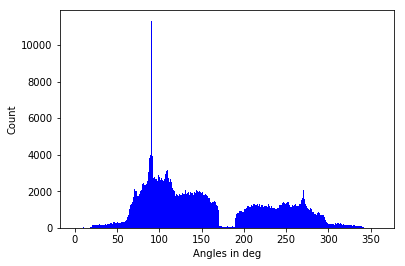

In [13]:
# angle distribution histogram
draw_hist(angles*180/math.pi,360,'blue','Angles in deg','Count')

In [14]:
# add number of edges column
n_edge = np.array([len(p) for p in poly[:,0]])
n_edge = n_edge.reshape((n_edge.shape[0],1))
poly = np.hstack((poly,n_edge))

(24000, 1)


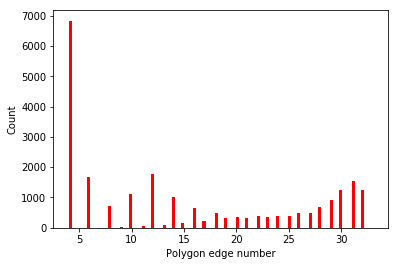

In [15]:
# histogram of number of edges
strat_edgeno = poly[:,2].copy()
strat_edgeno = strat_edgeno.reshape(-1, 1)
print(strat_edgeno.shape)
draw_hist(strat_edgeno,num_bins=100,color='red',xlabel='Polygon edge number',ylabel='Count')

In [16]:
poly = fix_single_class(poly, strat_edgeno)
#print(f'Out of f: {poly.shape}')

In [17]:
X_tv, X_test, y_tv, y_test = train_test_split(poly, lbl, test_size=0.2, stratify=poly[:,3])
print(f'X_TrainValidation: {X_tv.shape}\nX_test: {X_test.shape}\nytrainvalidation: {y_tv.shape}\nytest: {y_test.shape}')

X_TrainValidation: (19200, 4)
X_test: (4800, 4)
ytrainvalidation: (19200,)
ytest: (4800,)


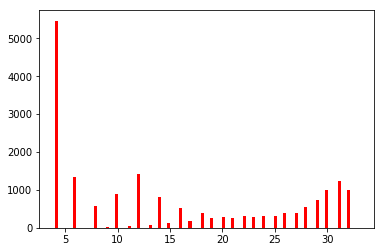

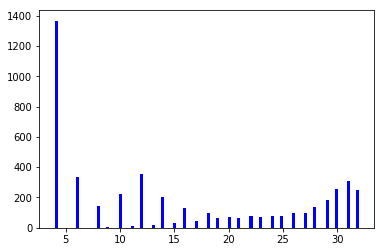

In [18]:
# test stratification
draw_hist(X_tv[:,2].reshape(-1,1),100)
draw_hist(X_test[:,2].reshape(-1,1),100,color='blue')

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.2, stratify=X_tv[:,3])
print(f'X_Train: {X_train.shape}\nX_validation: {X_val.shape}\nytrain: {y_train.shape}\nyvalidation: {y_val.shape}')

X_Train: (15360, 4)
X_validation: (3840, 4)
ytrain: (15360,)
yvalidation: (3840,)


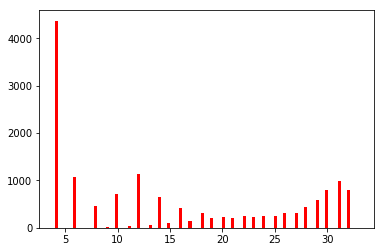

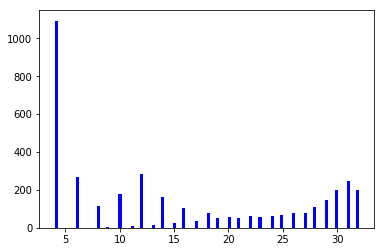

In [20]:
draw_hist(X_train[:,2].reshape(-1,1),100)
draw_hist(X_val[:,2].reshape(-1,1),100,color='blue')

In [21]:
X_train = np.delete(X_train, 3, 1)
X_val = np.delete(X_val, 3, 1)
X_test = np.delete(X_test, 3, 1)
# Check categorical
Y_train = y_train
Y_val = y_val
Y_test = y_test
#Y_train = to_categorical(y_train, 2)
#Y_test = to_categorical(y_test, 2)
#print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')


In [22]:
# Sort descending by number of angles - prep for batch padding
# TODO: think about removing because of masks usage
# FIX: sort validation if using batchsize bigger than 1 in val_generator
argsorted = X_train[:,2].argsort()[::-1]
X_train_sorted = X_train[argsorted]
Y_train_sorted = Y_train[argsorted]
# for i in range(len(X_train)):
#     if i == 32:
#         break
#     print(f'{X_train[i,2]} - {X_train_sorted[i,2]}')

In [23]:
del polygons
del poly
del strat_edgeno
del label
del lbl
del X_train
del y_train
del Y_train

In [24]:
X_train_sorted.shape

(15360, 3)

In [25]:
X_train_list = copy.deepcopy(X_train_sorted[:,:2].tolist())
X_val_list = copy.deepcopy(X_val[:,:2].tolist())
X_test_list = copy.deepcopy(X_test[:,:2].tolist())

Y_train_list = copy.deepcopy(Y_train_sorted.tolist())
Y_val_list = copy.deepcopy(Y_val.tolist())
Y_test_list = copy.deepcopy(Y_test.tolist())

In [26]:
#reshape list from (n_samples,channels,features) to (n_samples,features,channels)
for i in range(len(X_train_list)):
    X_train_list[i] = np.array(X_train_list[i]).T.tolist()
for i in range(len(X_val_list)):
    X_val_list[i] = np.array(X_val_list[i]).T.tolist()
for i in range(len(X_test_list)):
    X_test_list[i] = np.array(X_test_list[i]).T.tolist()


In [162]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, Lambda, BatchNormalization, Activation
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend
from tensorflow.debugging import is_numeric_tensor
from tensorflow.keras.optimizers import Adam
from tensorflow.losses import sigmoid_cross_entropy

#TODO: Test generator and padding first input with zeroes for training, maybe add first_kernel_size param
#TODO: Add angle number as feature (Konsult sa Mladjom)
#TODO: to_categorical
#TODO: Normalize the data
#TODO: Maybe shuffle batches before generator

In [28]:
# remove excess deepcopy
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, dX, dY, batch_size=32, pc_first_kernel_size=None, pad_zeros=True, mask_model=False):
        'Initialization'
        self.batch_size = batch_size
        self.dX = copy.deepcopy(dX)
        self.dY = copy.deepcopy(dY)
        self.cyclic_pad = pc_first_kernel_size-1 if pc_first_kernel_size != None else pc_first_kernel_size
        self.zero_pad = pad_zeros
        self.mask_model = mask_model

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dX) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        X, Y = self.__data_generation(index)

        return X, Y
   
    # Extend with creating mask at the same time
    def pad_zeros(self, xb, longest):
        # x = copy.deepcopy(xb)
        mask = []
        # diffs = list(map(lambda x : longest - x, map(len, xb)))
        for i in range(len(xb)):
            l = len(xb[i])
            xb[i].extend([[0, 0]]*(longest-l))
            # mask.append([[1, 1]]*l)
            # mask[i].extend([[0, 0]]*(longest-l))
            mask.append([[1]]*l)
            mask[i].extend([[0]]*(longest-l))
            # if l < longest:
            #     print(f'------------------------->{l} {longest}\n')
            #     for b, m in zip(xb[i],mask[i]):
            #         print(b, m)
                    
                
        return mask#, diffs
    
    # shortest poly has 4 edges, and first filter is 5
    def pad_cyclic(self, xb):
        # x = copy.deepcopy(xb)
        for i in range(len(xb)):
            #print(f'Before cyclic: {len(xb[i])}')
            xb[i].extend(xb[i][:self.cyclic_pad])
            #print(f'After cyclic: {len(xb[i])}')

    def __data_generation(self, index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        xb = copy.deepcopy(self.dX[index*self.batch_size:(index+1)*self.batch_size])
        yb = copy.deepcopy(self.dY[index*self.batch_size:(index+1)*self.batch_size])
        if self.cyclic_pad != None:
            self.pad_cyclic(xb)
        if self.zero_pad:
            longest = max(list(map(len, xb)))
            # print(f'Padding to size: {longest}')
            mask = self.pad_zeros(xb, longest)
            
        if self.mask_model:
            # return np.array(xb), np.array(yb)
            return [np.array(xb), np.array(mask)], np.array(yb)
        else:
            return np.array(xb), np.array(yb)
        # Initialization
        # X = np.empty((self.batch_size, longest, 2))
        # target 2 channels
        # Y = np.empty((self.batch_size, 1))
        # print(f'X shape:{X.shape} Y shape: {Y.shape})')
        # X=np.array(xb)
        # Y=np.array(yb)
        # print(f'X shape:{X.shape} Y shape: {Y.shape})')
        # print('--------------------------------------')        
        # if self.zero_pad:            print("TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT")
        #     M = np.array(mask)
        #     return [X, M], Y
        # else:
        #     return X, Y

In [29]:
class MyGlobalAveragePooling1D(tf.keras.layers.Layer):
    def __init__(self):
        super(MyGlobalAveragePooling1D, self).__init__()
    
    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()
        
        return tensor_shape.TensorShape([input_shape[0], input_shape[2]])
    
    def call(self, input, input_mask):
        mask = input_mask
        mask = math_ops.cast(mask, backend.floatx())
        #mask_shape = mask.shape.as_list()
        #input_shape = input.shape.as_list()
        
        #print(f'------------------------------------------->{input_shape}')
        #print(f'------------------------------------------->{mask_shape}')
        
        input *= mask
        
        return backend.sum(input, axis=1) / backend.sum(mask, axis=1)
        #return backend.mean(input, axis=1)


In [189]:
# Baseline - 97.8% :'(
def createModel():
    input = Input(shape = (None,2))
    x = Conv1D(filters=64,kernel_size=3,padding='valid', activation='relu')(input)
    #x = Conv1D(filters=64,kernel_size=5,padding='valid')(x) 
    x = GlobalAveragePooling1D()(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

# Baseline with 99 acc on old data set
def createMaskModelBaseline():
    inp = Input(shape = (None,2))
    mask = Input(shape = (None,1))
    
    x = Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu')(inp)
    m = Lambda(lambda x: x[:,2:,:])(mask) #output_shape=lambda input_shape: (input_shape[0],input_shape[1]-2,input_shape[2])
    # y = Conv1D(filters=64,kernel_size=3,padding='valid')(mask)
    #x = Conv1D(filters=64,kernel_size=3,padding='valid')(x)
    
    x = MyGlobalAveragePooling1D()(x, input_mask=m)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)

    output = Dense(1, activation='sigmoid')(x)
    m = Model(inputs=[inp, mask], outputs=output)
    
    return m
       
def createMaskModel():
    inp = Input(shape = (None,2))
    mask = Input(shape = (None,1))
    
    x = Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu')(inp)
    m = Lambda(lambda x: x[:,2:,:])(mask) #output_shape=lambda input_shape: (input_shape[0],input_shape[1]-2,input_shape[2])
    # y = Conv1D(filters=64,kernel_size=3,padding='valid')(mask)
    #x = Conv1D(filters=64,kernel_size=3,padding='valid')(x)
    
    x = MyGlobalAveragePooling1D()(x, input_mask=m)
    
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    output = Dense(1, activation='sigmoid')(x)
    m = Model(inputs=[inp, mask], outputs=output)
    
    return m

# Sa vise konvolucija, samo se preprilagodjava trening setu...
def createMaskModelDConv():
    inp = Input(shape = (None,2))
    mask = Input(shape = (None,1))
    
    x = Conv1D(filters=64,kernel_size=3,padding='valid', activation='relu')(inp)
    x = Conv1D(filters=32,kernel_size=3,padding='valid', activation='relu')(x)
    m = Lambda(lambda x: x[:,4:,:])(mask) #output_shape=lambda input_shape: (input_shape[0],input_shape[1]-2,input_shape[2])
    #m = Lambda(lambda x: x[:,4:,:])(m) #output_shape=lambda input_shape: (input_shape[0],input_shape[1]-2,input_shape[2])

    # y = Conv1D(filters=64,kernel_size=3,padding='valid')(mask)
    #x = Conv1D(filters=64,kernel_size=3,padding='valid')(x)
    
    x = MyGlobalAveragePooling1D()(x, input_mask=m)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)

    output = Dense(1, activation='sigmoid')(x)
    m = Model(inputs=[inp, mask], outputs=output)
    
    return m

# Ovako kompleksan model krene da overfituje - train val gap...
def createMaskModelDense():
    inp = Input(shape = (None,2))
    mask = Input(shape = (None,1))
    
    x = Conv1D(filters=256,kernel_size=3,padding='valid')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    m = Lambda(lambda x: x[:,4:,:])(mask) #output_shape=lambda input_shape: (input_shape[0],input_shape[1]-2,input_shape[2])
    # y = Conv1D(filters=64,kernel_size=3,padding='valid')(mask)
    #x = Conv1D(filters=64,kernel_size=3,padding='valid')(x)
    
    x = MyGlobalAveragePooling1D()(x, input_mask=m)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.33)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.33)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.33)(x)
    x = Dense(16, activation='relu')(x)

    output = Dense(1, activation='sigmoid')(x)
    m = Model(inputs=[inp, mask], outputs=output)
    
    return m

In [190]:
#prototype data for creating generator
# x = np.random.randn(32,30,2).tolist()
# x=x+np.random.randn(32,15,2).tolist()
# x=x+np.random.randn(32,17,2).tolist()
# x = np.array(x)
# print(x.shape)
# x=x.tolist()
# prob = [0.3, 0.7]
# y = np.random.choice([0,1], size=(96,1), p=prob).tolist()
# 
# X = np.random.randn(96,10,2)
# Y = np.random.choice([0,1], size=(96,1), p=prob)
# f = []
# f.append([[1]])
# print(f)
# f[0].extend([[2]]*2)
# print(f)

In [191]:
#train_generator = DataGenerator(X_train_list,Y_train_list,batch_size=64,pc_first_kernel_size=3,mask_model=True)
train_generator = DataGenerator(X_train_list,Y_train_list,batch_size=64,mask_model=True)
val_generator = DataGenerator(X_val_list, Y_val_list,batch_size=64,mask_model=True)
test_generator = DataGenerator(X_test_list,Y_test_list,batch_size=1,mask_model=True)

In [192]:
tf.keras.backend.clear_session()

In [193]:
model = createModel()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          448       
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [195]:
model.fit_generator(generator=train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    use_multiprocessing=False,
                    workers=0)

Epoch 1/100
240/240 [==============================] - 2s 8ms/step - loss: 0.0839 - acc: 0.9778 - val_loss: 0.1996 - val_acc: 0.9654
Epoch 2/100
240/240 [==============================] - 2s 8ms/step - loss: 0.0835 - acc: 0.9776 - val_loss: 0.1964 - val_acc: 0.9659
Epoch 3/100
240/240 [==============================] - 2s 8ms/step - loss: 0.0831 - acc: 0.9775 - val_loss: 0.1950 - val_acc: 0.9661
Epoch 4/100
240/240 [==============================] - 2s 8ms/step - loss: 0.0828 - acc: 0.9777 - val_loss: 0.1924 - val_acc: 0.9661
Epoch 5/100
240/240 [==============================] - 2s 8ms/step - loss: 0.0825 - acc: 0.9775 - val_loss: 0.1899 - val_acc: 0.9661
Epoch 6/100
240/240 [==============================] - 2s 8ms/step - loss: 0.0822 - acc: 0.9778 - val_loss: 0.1882 - val_acc: 0.9664
Epoch 7/100
240/240 [==============================] - 2s 9ms/step - loss: 0.0819 - acc: 0.9779 - val_loss: 0.1860 - val_acc: 0.9677
Epoch 8/100
240/240 [==============================] - 2s 10ms/step -

In [196]:
# print(len(X_train_list[0]))
# print(X_train_list[0])

#TODO: add pad = true attribute to generator

model.evaluate_generator(test_generator)

[0.08746347450761538, 0.97791666]

In [197]:
model.save('nomask_nocycl_baseline_e200_testacc978.h5')